##                                                             Here is the layout of this data migration project

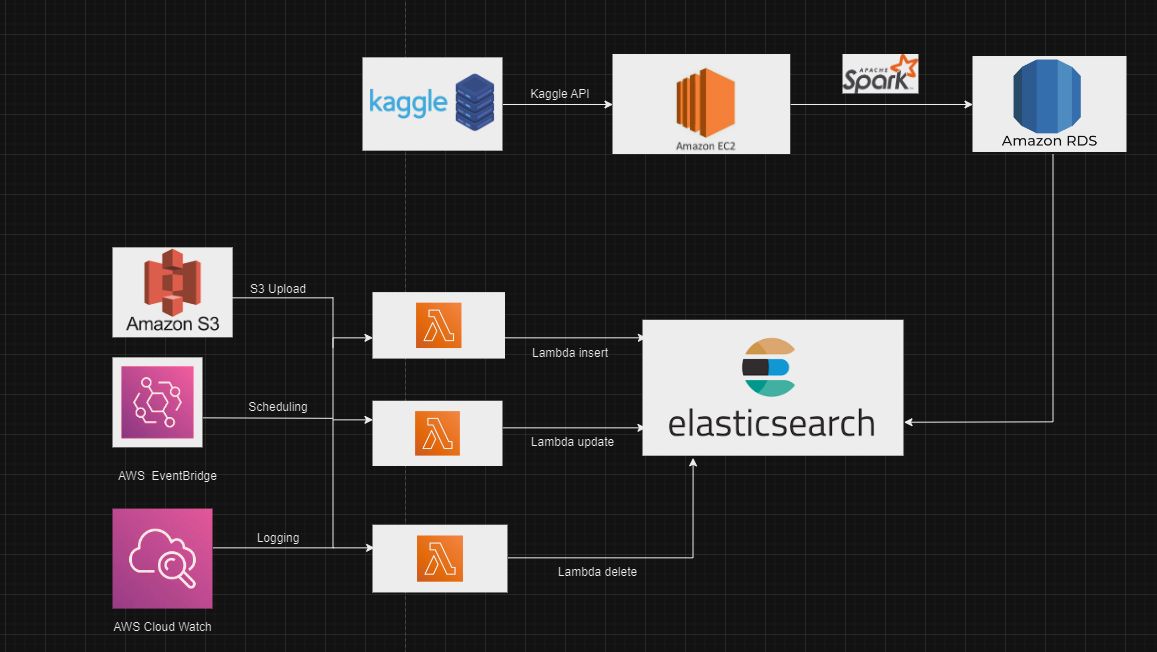

### Ingesting a 2 million records (2 GB) dataset from Kaggle into an AWS EC2 instance using the kaggle API 
### This is then sent to a PostgreSQL database known as AWS RDS using a spark job for faster processing. 
### The dataset ingested to RDS is then transferred to Elasticsearch and is stored as documents
### 3 python functions for updating , deleting and inserting records into elasticsearch are stoered in S3 and then imported as lambda functions
### These lambda functions are scheduled to run in different intervals using AWS EventBridge
### AWS CloudWatch monitors the logs of these lambda functions
### Let us take a look at this in more detail

### Getting the dataset from kaggle onto the EC2 instance is pretty straightforward, there is a command that helps us download kaggle data using a secret key

In [2]:
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews --force


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
100%|█████████████████████████████████████▉| 1.06G/1.06G [00:14<00:00, 73.7MB/s]
100%|██████████████████████████████████████| 1.06G/1.06G [00:14<00:00, 77.8MB/s]


In [9]:
import pandas as pd

In [10]:
pd.read_csv("books_data.csv").head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


#### Sending to a PostgreSQL server instance involves creating a RDS instance and using its endpoint to insert data. I've used a spark job here for faster transfer

In [8]:
!/opt/spark/bin/spark-submit --master local[2] code/csv_to_rds.py

24/09/02 13:31:59 INFO SparkContext: Running Spark version 3.5.2
24/09/02 13:31:59 INFO SparkContext: OS info Linux, 6.1.102-111.182.amzn2023.x86_64, amd64
24/09/02 13:31:59 INFO SparkContext: Java version 22.0.2
24/09/02 13:32:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/02 13:32:00 INFO ResourceUtils: ==============================================================
24/09/02 13:32:00 INFO ResourceUtils: No custom resources configured for spark.driver.
24/09/02 13:32:00 INFO ResourceUtils: ==============================================================
24/09/02 13:32:00 INFO SparkContext: Submitted application: CSV to RDS
24/09/02 13:32:00 INFO ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Ma

### Querying the RDS database to see if the table is populated

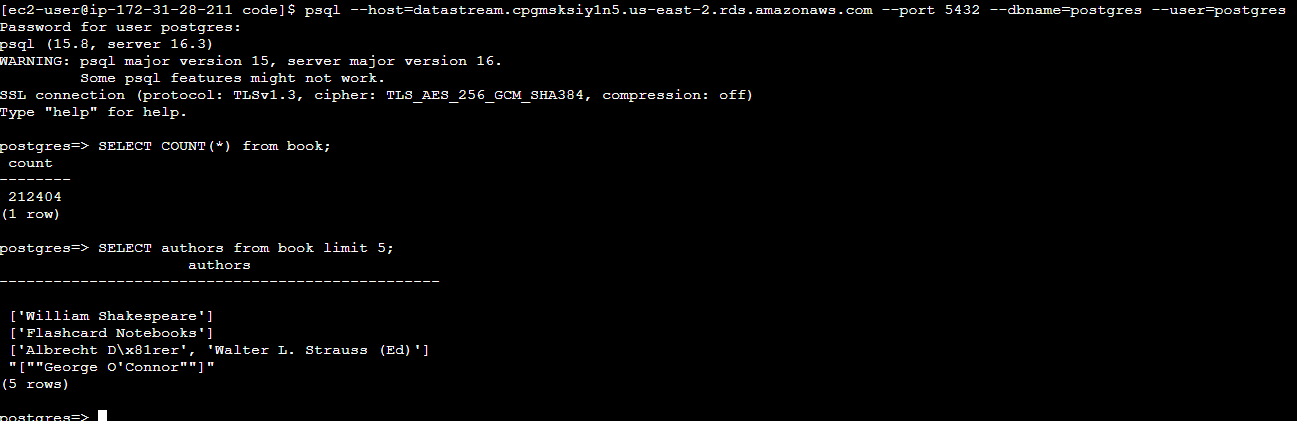

### Transferring the data from RDS to Elasticsearch

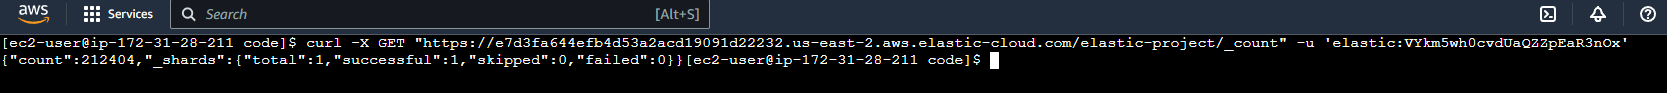

### The count mathces wth the RDS table count

## Updating the Elasticsearch table

### Updating the ratings_count column on 500 records every 30 minutes to increase the number of users who have left a rating

In [74]:
!curl -X GET "https://e7d3fa644efb4d53a2acd19091d22232.us-east-2.aws.elastic-cloud.com/elastic-project/_search?size=2&sort=title.keyword:desc" -u 'elastic:VYkm5wh0cvdUaQZZpEaR3nOx'

{"took":10,"timed_out":false,"_shards":{"total":1,"successful":1,"skipped":0,"failed":0},"hits":{"total":{"value":10000,"relation":"gte"},"max_score":null,"hits":[{"_index":"elastic-project","_id":"awlRs5EBZvh4MMvWMSmd","_score":null,"_ignored":["description.keyword"],"_source":{"title":"zzUgraEeSqSDtPGRefTX","description":"\"At the end of the day, what better place is there to kick back, chill out and make the world go away, than in your own backyard garden? Plant and cocktail lover C. L. Fornari shows how easy it is to create a garden atmosphere that sets the mood for private relaxation or festive occasions with friends. With a wise and witty text, mood-setting plant lists, botanical drink recipes and luscious photographs, The Cocktail Hour Garden reveals the simple secrets to creating an evening pleasure garden. This personalizing of the garden experience is what the new buzzwords \"\"garden-tainment\"\" and \"\"garden-to-glass\"\" are all about.\"","authors":"['C. L. Fornari']","im

### The ratings_count for record 1 is NULL and the ratings_count for the record 2 is 1.0 -> Let's increment that using a lambda function

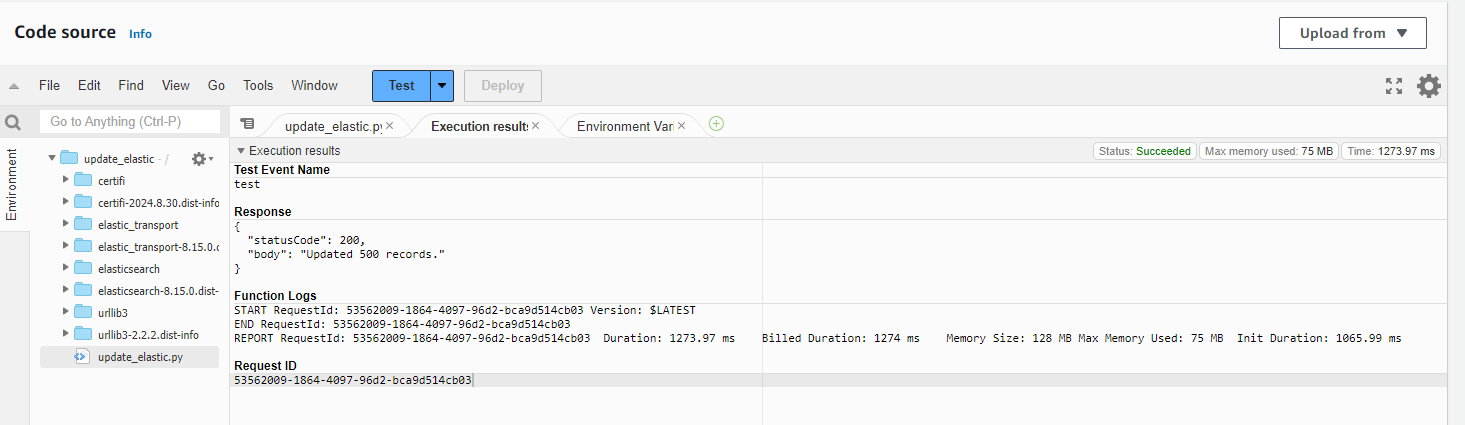

In [75]:
!curl -X GET "https://e7d3fa644efb4d53a2acd19091d22232.us-east-2.aws.elastic-cloud.com/elastic-project/_search?size=2&sort=title.keyword:desc" -u 'elastic:VYkm5wh0cvdUaQZZpEaR3nOx'

{"took":10,"timed_out":false,"_shards":{"total":1,"successful":1,"skipped":0,"failed":0},"hits":{"total":{"value":10000,"relation":"gte"},"max_score":null,"hits":[{"_index":"elastic-project","_id":"awlRs5EBZvh4MMvWMSmd","_score":null,"_ignored":["description.keyword"],"_source":{"title":"zzUgraEeSqSDtPGRefTX","description":"\"At the end of the day, what better place is there to kick back, chill out and make the world go away, than in your own backyard garden? Plant and cocktail lover C. L. Fornari shows how easy it is to create a garden atmosphere that sets the mood for private relaxation or festive occasions with friends. With a wise and witty text, mood-setting plant lists, botanical drink recipes and luscious photographs, The Cocktail Hour Garden reveals the simple secrets to creating an evening pleasure garden. This personalizing of the garden experience is what the new buzzwords \"\"garden-tainment\"\" and \"\"garden-to-glass\"\" are all about.\"","authors":"['C. L. Fornari']","im

### rating count for record 1 has now changed to 1 and rating count for record 2 has changed to 2

## This is also scheduled to run every 30 minutes using EventBridge

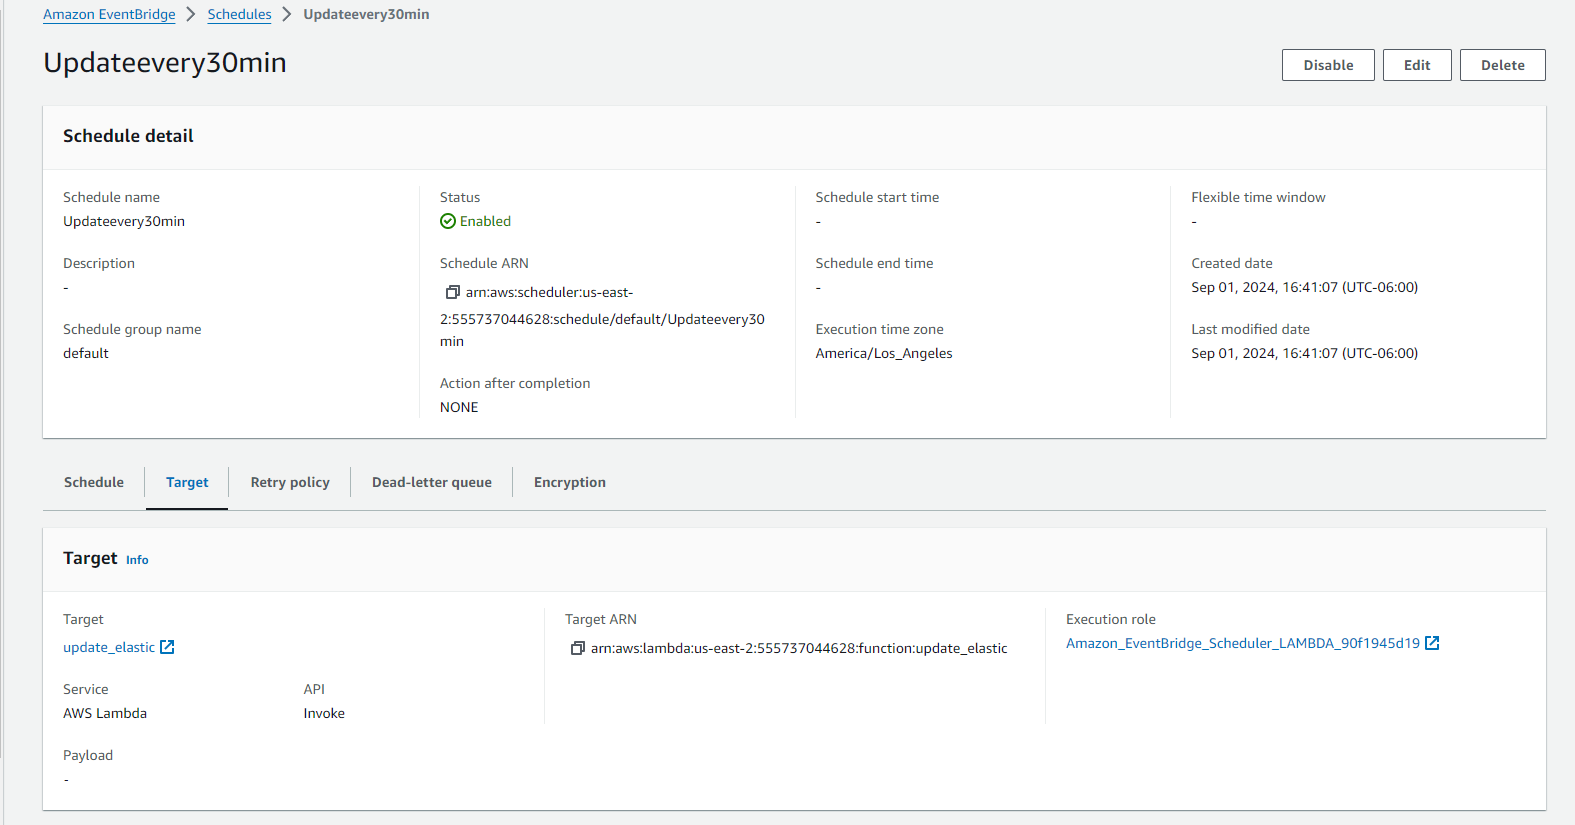

### The logs can be monitored using CloudWatch

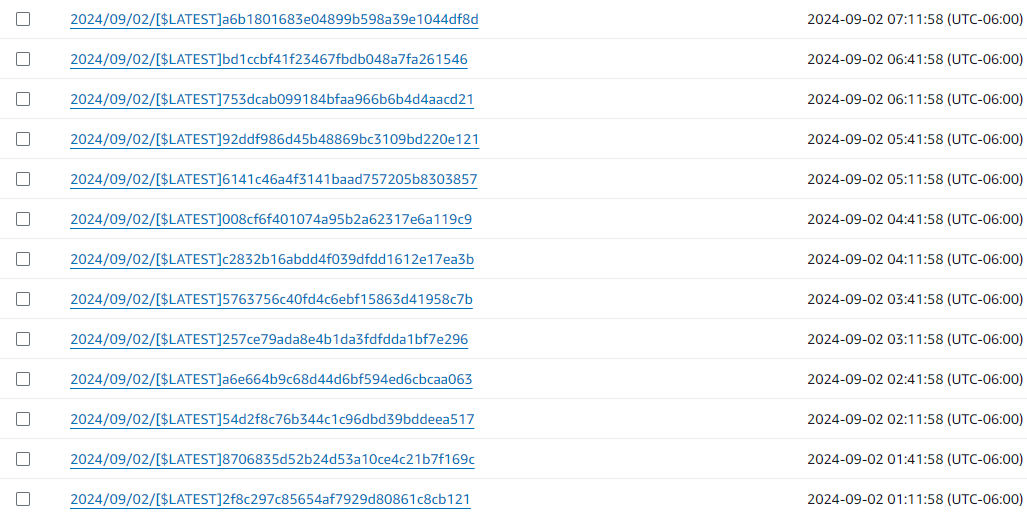

## Adding and Deleting records in Elasticserch

### Here is the current count of records in the index

!curl -X GET "https://e7d3fa644efb4d53a2acd19091d22232.us-east-2.aws.elastic-cloud.com/elastic-project/_count" -u 'elastic:VYkm5wh0cvdUaQZZpEaR3nOx'

### Let's trigger the add records lambda function which generates a random title and uses the other existing colums to create 2000 new rows

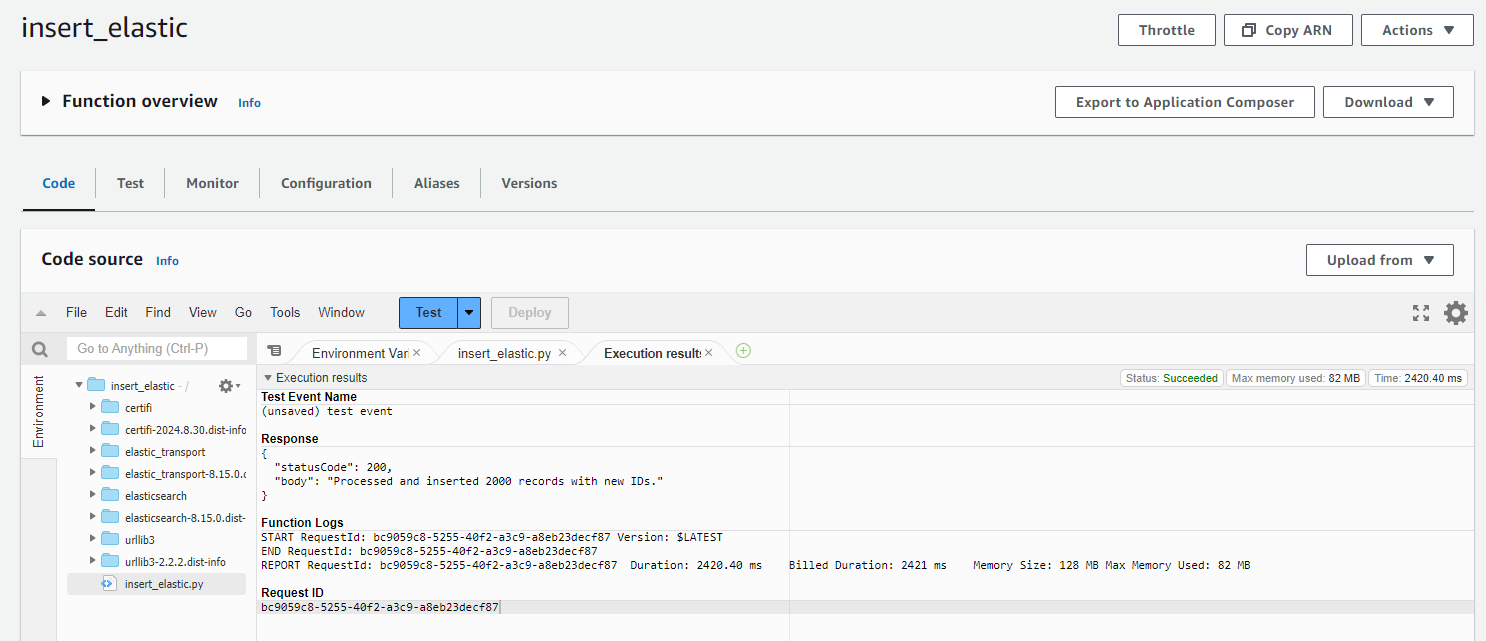

In [5]:
!curl -X GET "https://e7d3fa644efb4d53a2acd19091d22232.us-east-2.aws.elastic-cloud.com/elastic-project/_count" -u 'elastic:VYkm5wh0cvdUaQZZpEaR3nOx'

{"count":221404,"_shards":{"total":1,"successful":1,"skipped":0,"failed":0}}

### Let's trigger the delete records lambda function to remove 1000 records

In [7]:
!curl -X GET "https://e7d3fa644efb4d53a2acd19091d22232.us-east-2.aws.elastic-cloud.com/elastic-project/_count" -u 'elastic:VYkm5wh0cvdUaQZZpEaR3nOx'

{"count":220404,"_shards":{"total":1,"successful":1,"skipped":0,"failed":0}}

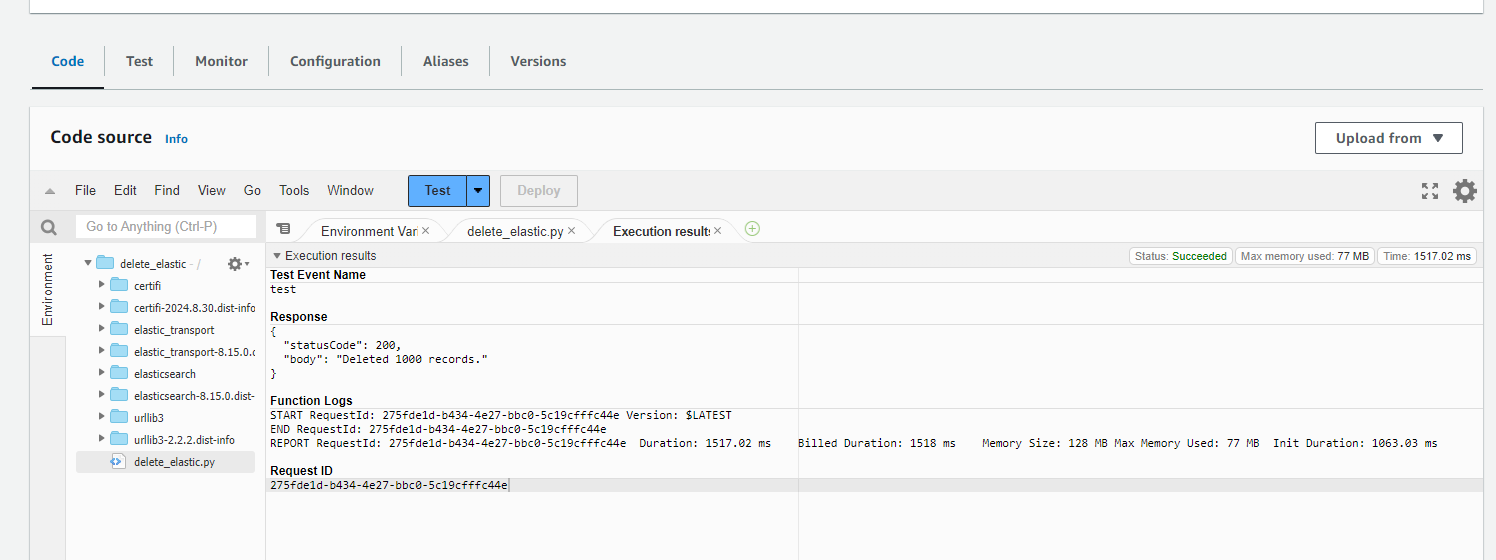

### These are also scheduled for 45 minutes and 30 minutes respectively using EventTrigger and monitored using CloudWatch